# Extreme Value Anlaysis using daily Precipitation data from Cal-Adapt API

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats.distributions import genpareto
from scipy import special
from scipy import optimize

import logging
LOG = logging.getLogger(__name__)

----
# Download data
----

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are mm and projected data are in kg/m2/s.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given a slug and params
    - convert units to inches
    - return a new Pandas dataframe that contains all the data

In [2]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

# Params
point = 'POINT(-121.4687 38.5938)'
params = {'g': point}

def mm_to_inches(val):
    return val * 0.0393701

def kgm2s_to_inches(val):
    return  (val * 86400) * 0.0393701

In [3]:
def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        if units == 'mm':
            df.value = df.value.apply(lambda x: mm_to_inches(x))
        elif units == 'kg/m2/s':
            df.value = df.value.apply(lambda x: kgm2s_to_inches(x))
        else:
            pass
            
        # Add slug as a column
        df['series'] = slug.split('_')[2]
        
        # Add wateryear as a column
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['wateryear'] = np.where(df['month'] > 9, df['year'] + 1, df['year'])

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [4]:
# Download observed daily timeseries
def get_observed():
    # Create slug
    slug = 'pr_day_livneh'
    df = process_daily_data(slug, params)
    return df

df = get_observed()
df

Processing: pr_day_livneh


,value,series,year,month,wateryear
1950-01-01,0.021879,livneh,1950,1,1950
1950-01-02,0.038984,livneh,1950,1,1950
1950-01-03,0.000000,livneh,1950,1,1950
1950-01-04,0.000000,livneh,1950,1,1950
1950-01-05,0.000000,livneh,1950,1,1950
1950-01-06,0.000000,livneh,1950,1,1950
1950-01-07,0.278853,livneh,1950,1,1950
1950-01-08,0.227935,livneh,1950,1,1950
1950-01-09,0.043757,livneh,1950,1,1950
1950-01-10,0.640446,livneh,1950,1,1950


----
# Select Threshold
----

Using a baseline period of wateryears 1961 - 1990, calculate the 90th, 95th and 99th percentiles of daily precipitation values within a water year from the observed data. Count number of days with values above threshold.

In [5]:
# CALCULATE THRESHOLDS

# Filter data by baseline time period
baselineDF = df.loc[(df['wateryear'] >= 1961) & (df['wateryear'] <= 1990) & (df['series'] == 'livneh')]

# Filter out zero precip values
baseline_nonzero = baselineDF.loc[(baselineDF['value'] > 0)]
threshold90 = baseline_nonzero['value'].quantile(0.90, interpolation='linear')
threshold95 = baseline_nonzero['value'].quantile(0.95, interpolation='linear')
threshold99 = baseline_nonzero['value'].quantile(0.99, interpolation='linear')

print('90th Percentile =', round(threshold90, 2), 'inch/day')
print('95th Percentile =', round(threshold95, 2), 'inch/day')
print('99th Percentile =', round(threshold99, 2), 'inch/day')

# Create Annual Maximum Series
baselineDF_max = baselineDF.groupby('wateryear').value.max()
threshold_minAMS = np.min(baselineDF_max)
print('Lowest value from Annual Maximum Series =', round(threshold_minAMS, 2), 'inch/day')

90th Percentile = 0.62 inch/day
95th Percentile = 0.87 inch/day
99th Percentile = 1.57 inch/day
Lowest value from Annual Maximum Series = 0.64 inch/day


----
# Extreme Value Analysis using Peak Over Threshold
----

Problem: Using Quantiles as threshold value in dry location has too few occurrences to meet requirements of statistical tests.

Solution: use minimum of annual maximum precipitation as threshold rather than percentiles (as default)

Question: Should we round this value?
286 exceedances above 0.6
255 exceedances above 0.64
257 exceedances above 0.635175897766

In [13]:
# Set threshold value to lowest value of Annual Maximum Series
threshold = threshold_minAMS
threshold = round(threshold_minAMS, 1)
print(threshold)

0.6


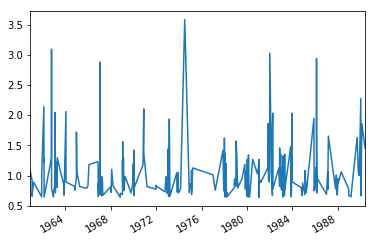

In [14]:
baselineDF.loc[baselineDF['value'] > threshold_minAMS].value.plot()

In [15]:
# Create a Partial duration series
PDS = baselineDF['value'].values
print('Number of observations =', len(PDS))
print('Number of exceedances =', (PDS > threshold).sum())

Number of observations = 10957
Number of exceedances = 286


In [16]:
## TODO: Remove back to back events from PDS

In [17]:
# Functions adapted from https://github.com/wcarthur/extremes

def returnLevels(intervals, mu, xi, sigma, rate, npyr):
    """
    Calculate return levels for specified intervals for a generalised pareto
    distribution with the given threshold, scale and shape parameters.

    :param intervals: :class:`numpy.ndarray` or float of recurrence intervals
              to evaluate return levels for.
    :param float mu: Threshold parameter (also called location).
    :param float xi: Shape parameter.
    :param float sigma: Scale parameter.
    :param float rate: Rate of exceedances (i.e. number of observations greater
                       than `mu`, divided by total number of observations).
    :param float npyr: Number of observations per year.

    :returns: return levels for the specified recurrence intervals.

    """

    rlevels = mu + (sigma / xi) * (np.power(intervals * npyr * rate, xi) - 1.)
    return rlevels

def empReturnPeriod(data, npyr):
    """
    Returns the empirically-based recurrence interval (in years) for a set
    of observations.

    It is assumed the data are daily observations. If the observations are not
    daily, there are two options: set the ``npyr`` variable, or backfill the
    ``data`` variable with zero values to match the assumed length of the
    record.

    The highest return period should be (approximately) len(``data``)/``npyr``.

    :param data: :class:`numpy.ndarray` containing the observed values (with
                 missing values removed).
    :param float npy: Number of observations per year (default=365.25)

    :returns: Recurrence intervals for the observed data.
    :rtype: :class:`numpy.ndarray`
    """
    nobs = len(data)
    # Empirical return periods:
    emprp = 1. / (1. - np.arange(1, nobs + 1, 1) / (nobs + 1)) / npyr
    return emprp

In [18]:
def fitData(data, mu):
    """
    Calculate parameter estimates for shape and scale while holding the location at threshold value.
    Freeze the distribution using these parameters estimates.
    :param data: :class:`numpy.ndarray` of data values (partial duration series)
    :param float mu: Threshold value
    :returns: Frozen distribution and parameter estimates
    """
    LOG.debug("Fitting data")
    params = genpareto.fit(data[data > mu], floc=mu)
    fit = genpareto(*params)
    return (fit, params)

In [19]:
def plotDiagnostics(data, mu):
    """
    Create a 4-panel diagnostics plot of the fitted distribution.
    :param data: :class:`numpy.ndarray` of observed data values
    :param float mu: Selected threshold value.
    """
    LOG.info("Plotting diagnostics")
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    axes = ax.flatten()
    
    # Get the frozen distribution object and parameter estimates
    gpa_fit, params = fitData(data, mu)
    
    exceedances = np.sort(data[data > mu])
    
    # PROBABILITY PLOT
    N = len(exceedances)
    x = gpa_fit.cdf(exceedances)
    y = np.arange(1, N + 1) / (N + 1)
    
    ax0 = axes[0]
    ax0.scatter(x, y, color = 'r')
    ax0.plot([0, 1], [0, 1])
    ax0.set_xlim(0, 1)
    ax0.set_ylim(0, 1)
    ax0.set_xlabel('Model')
    ax0.set_ylabel('Empirical')
    ax0.set_title('Probability Plot')


    # QUANTILE PLOT
    # Not sure if this is the correct way to plot quantile plot
    vals = np.arange(0.1, 1, 0.01)
    x = gpa_fit.ppf(vals)
    y = genpareto.ppf(vals, c=0.1, loc=mu)
    
    ax1 = axes[1]
    ax1.scatter(x, y, color = 'r')
    ax1.set_xlabel("Model")
    ax1.set_ylabel("Empirical")
    ax1.set_title('Quantile Plot')

    # RETURN LEVEL PLOT
    # Return periods/intervals
    rp = np.array([1, 2, 5, 10, 20, 50, 100])
    # Rate of exceedances (i.e. number of observations greater than `mu`, divided by total number of observations).
    rate = float(len(exceedances)) / float(len(data))
    # Number of observations per year. We are looking at a 30 year period in this example.
    npyr = len(data) / 30
    # Return levels
    rval = returnLevels(rp, mu, params[0], params[2], rate, npyr)
    # Empirical return levels
    emprp = empReturnPeriod(data, npyr)
    sorted_data = np.sort(data)
    
    ax2 = axes[2]
    ax2.semilogx(rp, rval, label="Fitted RP curve")
    ax2.scatter(emprp[emprp > 1], sorted_data[emprp > 1], color='r', label="Empirical RP", s=100)
    ax2.set_xlabel("Return period")
    ax2.set_ylabel("Return level")
    ax2.set_title("Return level plot")
    ax2.legend(loc='best', frameon=False)
    ax2.grid(True)
    
    # DENSITY PLOT
    x = np.linspace(gpa_fit.ppf(0.001), gpa_fit.ppf(0.999), 100)
    
    ax3 = axes[3]
    ax3.plot(x, gpa_fit.pdf(x), label = 'Modeled')
    ax3.hist(exceedances, density = True, color = 'yellow', alpha = 0.75, label = "Empirical")
    ax3.set_xlabel('Precipitation')
    ax3.set_ylabel('Probability')
    ax3.set_title('Density Plot')
    ax3.legend(loc='best', frameon=False)
    
    plt.tight_layout()

/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:1753: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


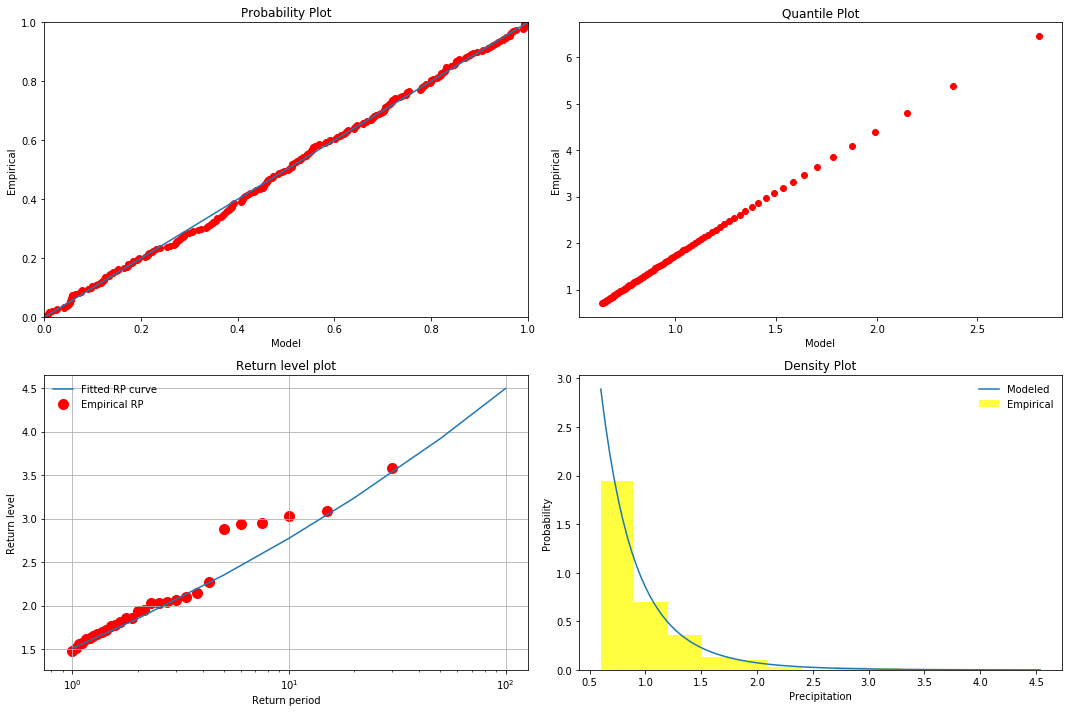

In [20]:
plotDiagnostics(PDS, threshold)

---
# Calculating Profile Likelihood Confidence Intervals for a Return Level
---

### Results from eva package using Profile method

| RP | Estimate | CI |
| :------------- | :----------: | -----------: |
|2 | 1.850149 | 1.682067 2.100018 |
|5 | 2.351029 | 2.066932 2.845611 |
|10 | 2.773079 | 2.362567 3.554957 |
|20 | 3.236324 | 2.661167 4.418990 |
|50 | 3.918808 | 3.060282 5.855717 |
|100 | 4.493882 | 3.365654 7.219048 |

The following function calculates the return level and confidence intervals for one interval at time.


In [21]:
# Function adapted from R library eva - https://github.com/geekman1/eva_package/blob/master/R/gpdRl.R

def returnLevelWithCI(period, mu, xi, sigma, data, conf=0.95):
    """
    Calculate return level with Confidence Interval for a specified period for a generalised pareto
    distribution with the given threshold, scale and shape parameters.

    :param float period: Recurrence interval
    :param float mu: Threshold parameter (also called location).
    :param float sigma: Scale parameter.
    :param float xi: Shape parameter.
    :param ndarray data: Partial Duration Series
    :param float conf: The confidence level used.
    :returns: return level for the specified recurrence interval.

    """
    # Rate of exceedances (i.e. number of observations greater than `mu`, divided by total number of observations).
    rate = float(len(data[data > mu])) / float(len(data))
    # Number of observations per year.
    npyr = len(data) / 30
    m = period * npyr
    # Quantile of chi**2 distribution
    cutoff =  special.chdtri(1, 1 - conf)
    # Sum of log of the probability density function for dataset
    lmax = np.sum(genpareto.logpdf(data[data > mu], c=xi, loc=mu, scale=sigma))
    # The largest in magnitude usable floating value.
    XMAX = np.finfo(float).max
    
    # Log Likelihood function
    def gpdlik(shape, xp):
        if (shape == 0):
            scale = (xp - mu) / np.log(m * rate)
        else:
            scale = ((xp - mu) * shape) / (np.power(m * rate, shape) - 1)
        
        if (scale <= 0):
            out = XMAX
        else:
            out = genpareto.logpdf(data[data > mu], c=shape, loc=mu, scale=scale)
            out = np.sum(out)
            if(out == float('Inf')):
                out = XMAX
        return -out

    # Profile Likelihood function
    def prof(xp):
        yes = optimize.minimize(gpdlik, [xi], args=(xp,))
        lci = -yes.fun
        return 2*(lmax-lci) - cutoff
    
    # Calculate return level
    est = mu + (sigma / xi) * (np.power(m * rate, xi) - 1.)
    print('Return Level for {} year return period: {}'.format(period, est))
    
    # Guess for initial bounds. Don't know if these guesses will work for all locations.
    lower_bound = est**0.5
    upper_bound = est**2
    
    # Calculate confidence intervals
    try:
        ci_upper = optimize.brentq(prof, est, upper_bound)
        print('Confidence Interval (upper):', ci_upper)
    except ValueError as e:
        print('Confidence Interval (upper):', e)
        
    try:
        ci_lower = optimize.brentq(prof, est, lower_bound)
        print('Confidence Interval (lower):', ci_lower)
    except ValueError as e:
        print('Confidence Interval (lower):', e)

In [22]:
# Get the frozen distribution object and parameter estimates
gpa_fit, params = fitData(PDS, threshold)
returnLevelWithCI(100, threshold, params[0], params[2], PDS)

/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:1753: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + 

Return Level for 100 year return period: 4.495072804132461
Confidence Interval (upper): 7.220416903611633
Confidence Interval (lower): 3.365955147163392


/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_sc